In [2]:
import pandas as pd
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import FunctionTransformer
from scipy import stats

from sklearn import linear_model
from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import ShuffleSplit

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from lightgbm import LGBMRegressor
from lightgbm import plot_importance
from sklearn.model_selection import ParameterSampler, RandomizedSearchCV
import shap

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
print(pd.__version__)
import matplotlib
print(matplotlib.__version__)
print(sns.__version__)
print(np.__version__)
import sklearn
print(sklearn.__version__)
import scipy
print(scipy.__version__)
import statsmodels
print(statsmodels.__version__)
import lightgbm
print(lightgbm.__version__)
print(shap.__version__)

0.24.1
3.0.2
0.9.0
1.15.4
0.20.2
1.1.0
0.9.0
2.2.1
0.28.3


### 각 데이터 속성별 탐색 과정
다운 받은 파일을 읽습니다.<br>
공백이 여러개 있기 때문에 바로 pandas dataframe 으로 읽지는 못하고, 파일 리드 후에 라인별로 처리하여 리스트 만들어서 칼럼명을 지정해주며 pandas dataframe으로 생성합니다.<br>
읽어온 데이터 샘플을 확인해보고, 줄수와 칼럼수를 확인합니다.

In [4]:
raw = open('../housing.data','r')
data = []
for line in raw.readlines():
    row = []
    for val in line.split(' '):
        if val != '': row.append(float(val.strip()))
    #print(row)
    data.append(row)
data = pd.DataFrame(data,columns = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B1000','LSTAT','MEDV'])

display(data.head())
print(data.shape)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B1000,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


(506, 14)


간단하게 피쳐별로 타겟에 대한 코릴레이션을 확인합니다. <br>
LSTAT, RM, PTRATIO 가 절대값 0.5를 넘는 것으로 타겟값과 코릴레이션이 높은 변수들이 있는 것은 예측에서 유용하게 쓰일 것을 가늠할 수 있습니다. 

In [5]:
data.corr().iloc[:, -1]
### 타겟값에 코릴레이션이 높은 변수들이 있음 LSTAT, RM, PTRATIO 가 절대값 0.5를 넘음

CRIM      -0.388305
ZN         0.360445
INDUS     -0.483725
CHAS       0.175260
NOX       -0.427321
RM         0.695360
AGE       -0.376955
DIS        0.249929
RAD       -0.381626
TAX       -0.468536
PTRATIO   -0.507787
B1000      0.333461
LSTAT     -0.737663
MEDV       1.000000
Name: MEDV, dtype: float64

#### 변수 전처리 (정규화, 스케일링)
트리 기반이 아닌 대부분은 모형 (linear regression, neural net) 의 사용을 위해서는 수치형 변수는 정규분포가 아니라면, 정규 분포를 따르도록 변환해줘야 합니다.
수치형 변수들을 선별 합니다.


In [6]:
numcols = list(set(data.columns) - set(['CHAS','MEDV']))
numcols

['RAD',
 'AGE',
 'DIS',
 'LSTAT',
 'PTRATIO',
 'ZN',
 'CRIM',
 'NOX',
 'INDUS',
 'RM',
 'TAX',
 'B1000']

이제 수치형 변수들에 대해서 변수별로 분포를 관찰하며 정규화가 필요한 경우 적당한 변수 변환 방법들을 선택해야합니다.<br>
변수를 정규화 하기 위해서는 로그 변환, box-cox 변환, quantile 변환을 많이 사용합니다.<br>
변환후 qqplot 을 그려서 정규성을 따르는지 확인합니다.<br>

RAD


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


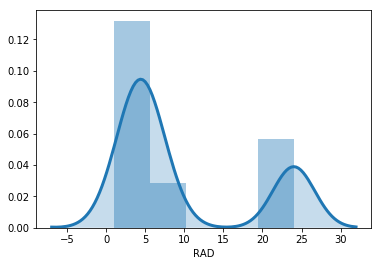

count    506.000000
mean       9.549407
std        8.707259
min        1.000000
25%        4.000000
50%        5.000000
75%       24.000000
max       24.000000
Name: RAD, dtype: float64


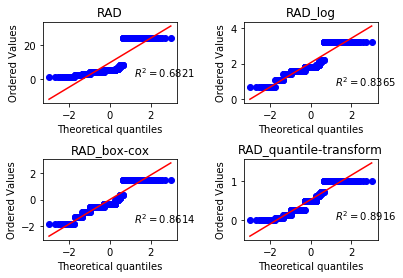

AGE


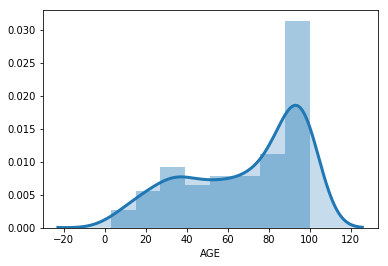

count    506.000000
mean      68.574901
std       28.148861
min        2.900000
25%       45.025000
50%       77.500000
75%       94.075000
max      100.000000
Name: AGE, dtype: float64


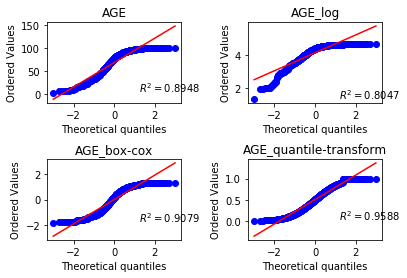

DIS


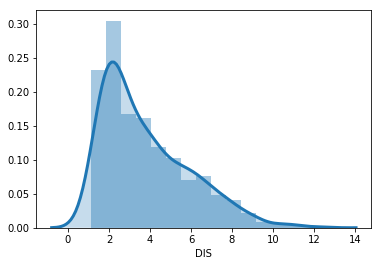

count    506.000000
mean       3.795043
std        2.105710
min        1.129600
25%        2.100175
50%        3.207450
75%        5.188425
max       12.126500
Name: DIS, dtype: float64


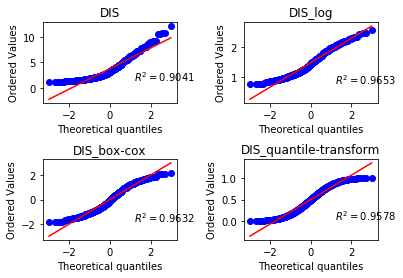

LSTAT


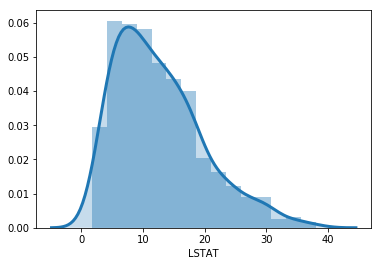

count    506.000000
mean      12.653063
std        7.141062
min        1.730000
25%        6.950000
50%       11.360000
75%       16.955000
max       37.970000
Name: LSTAT, dtype: float64


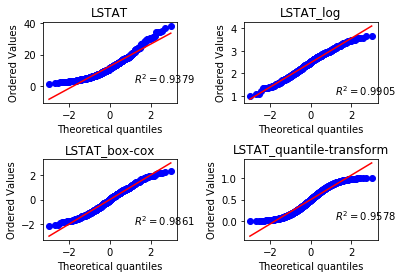

PTRATIO


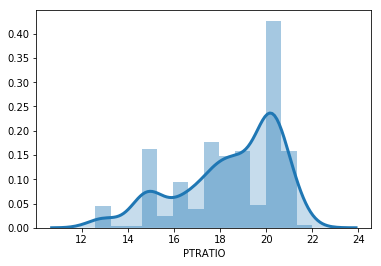

count    506.000000
mean      18.455534
std        2.164946
min       12.600000
25%       17.400000
50%       19.050000
75%       20.200000
max       22.000000
Name: PTRATIO, dtype: float64


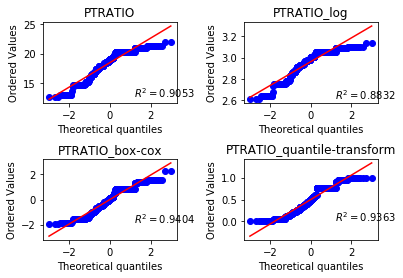

ZN


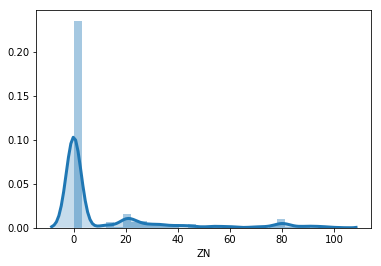

count    506.000000
mean      11.363636
std       23.322453
min        0.000000
25%        0.000000
50%        0.000000
75%       12.500000
max      100.000000
Name: ZN, dtype: float64


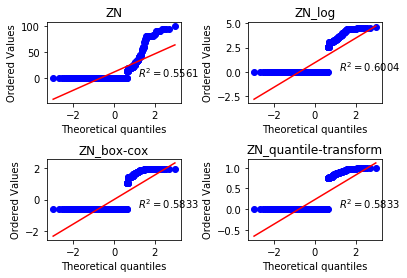

CRIM


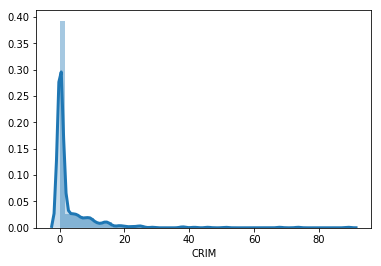

count    506.000000
mean       3.613524
std        8.601545
min        0.006320
25%        0.082045
50%        0.256510
75%        3.677083
max       88.976200
Name: CRIM, dtype: float64


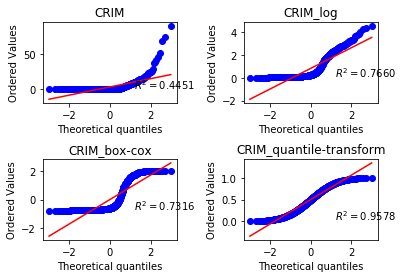

NOX


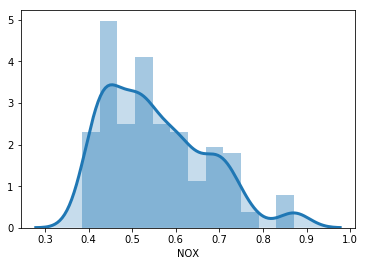

count    506.000000
mean       0.554695
std        0.115878
min        0.385000
25%        0.449000
50%        0.538000
75%        0.624000
max        0.871000
Name: NOX, dtype: float64


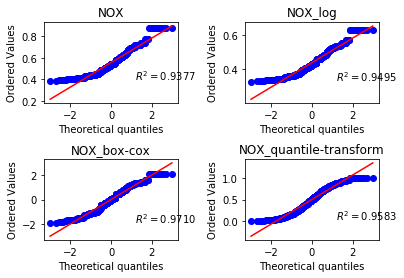

INDUS


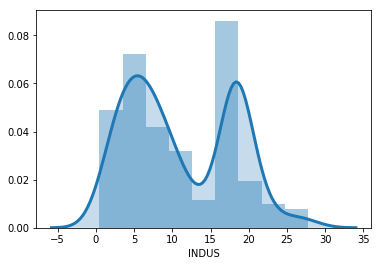

count    506.000000
mean      11.136779
std        6.860353
min        0.460000
25%        5.190000
50%        9.690000
75%       18.100000
max       27.740000
Name: INDUS, dtype: float64


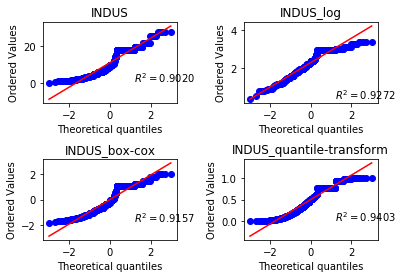

RM


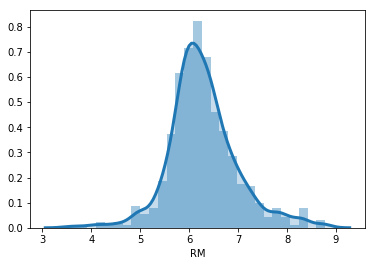

count    506.000000
mean       6.284634
std        0.702617
min        3.561000
25%        5.885500
50%        6.208500
75%        6.623500
max        8.780000
Name: RM, dtype: float64


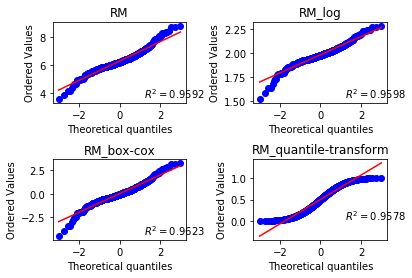

TAX


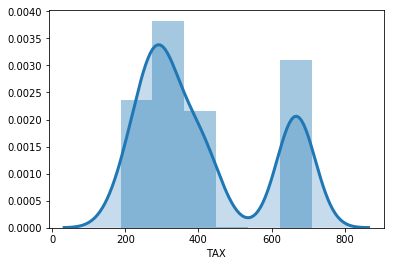

count    506.000000
mean     408.237154
std      168.537116
min      187.000000
25%      279.000000
50%      330.000000
75%      666.000000
max      711.000000
Name: TAX, dtype: float64


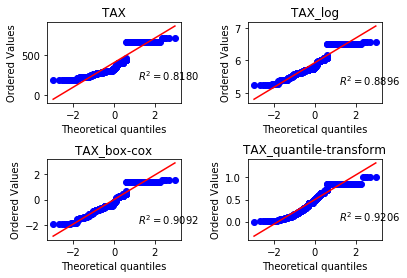

B1000


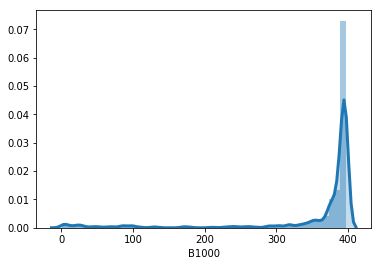

count    506.000000
mean     356.674032
std       91.294864
min        0.320000
25%      375.377500
50%      391.440000
75%      396.225000
max      396.900000
Name: B1000, dtype: float64


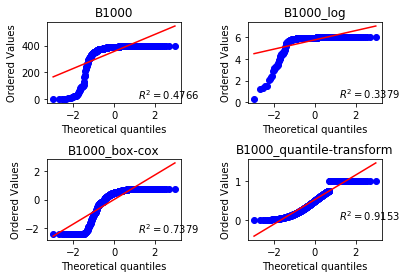

In [7]:
%matplotlib inline
## 정규성 검사 및 정규화; 트리 기반이 아닌 대부분의 모형을 위해서는 수치 변수는 정규분포가 아니라면, 
## 정규 분포를 따르도록 변환해줘야 한다.
### 로그 트랜스폼으로 정규화
pt = FunctionTransformer(np.log1p, validate=True)
nums = pt.fit_transform(data.loc[:,numcols])
numslog = pd.DataFrame(nums,columns=[s +  '_logt' for s in numcols])


### 파워트랜스폼 방법 1 박스 콕스 ; 사전에 양수로 만들어주기 위해서 스케일 조정 및 시프트
pt = preprocessing.MinMaxScaler()
nums = pt.fit_transform(data.loc[:,numcols])
numsmm = pd.DataFrame(nums,columns=[s +  '_mm' for s in numcols])
pt = preprocessing.PowerTransformer(method='box-cox', standardize=True)
nums = pt.fit_transform(numsmm + 1)
numsbc = pd.DataFrame(nums,columns=[s +  '_bct' for s in numcols])


### 퀀타일 트랜스폼
quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
nums = quantile_transformer.fit_transform(data.loc[:,numcols])
numsqt = pd.DataFrame(nums,columns=[s +  '_qt' for s in numcols])

nums = data.loc[:,numcols]

for col in range(0,len(numcols)):
    print(numcols[col])

    sns.distplot(nums.iloc[:,col], hist = True, kde = True, label='>50K',
                 kde_kws = {'shade': True, 'linewidth': 3})
    plt.show()

    pdd = nums.iloc[:,col].describe()
    print(pdd)
    
    ax1 = plt.subplot(221)
    stats.probplot(nums.iloc[:,col], dist=stats.norm,plot=ax1,rvalue=True)
    ax1.set_title(numcols[col])
    ax2 = plt.subplot(222)
    stats.probplot(numslog.iloc[:,col], dist=stats.norm,plot=ax2,rvalue=True)
    ax2.set_title(numcols[col] + '_log')
    ax3 = plt.subplot(223)
    stats.probplot(numsbc.iloc[:,col], dist=stats.norm,plot=ax3,rvalue=True)
    ax3.set_title(numcols[col] + '_box-cox')
    ax4 = plt.subplot(224)
    stats.probplot(numsqt.iloc[:,col], dist=stats.norm,plot=ax4,rvalue=True)
    ax4.set_title(numcols[col] + '_quantile-transform')
    plt.subplots_adjust(hspace = 0.7, wspace = 0.5)

    plt.show()
    
    ## quantile_transform ; AGE, TAX, B1000, INDUS, CRIM
    ## log ; DIS, LSTAT
    ## box-cox ; PTRATIO
    ## 그대로 NOX, RM
    ## RAD, ZN 정규화가 잘 안되므로, 구간화하여서 원핫

모든 수치형 변수들에 대해서 확인한 결과 아래와 같은 변환 방법으로 적용합니다.
- quantile_transform ; AGE, TAX, B1000, INDUS, CRIM
- log ; DIS, LSTAT
- box-cox ; PTRATIO
- 그대로 NOX, RM
- RAD, ZN 정규화가 잘 안되므로, 구간화하여서 원핫

In [8]:
## 변수 처리

## 로그 트랜스폼 대상 변수 
nclog = ['DIS', 'LSTAT']
numslog = data.loc[:,nclog]
pt = FunctionTransformer(np.log1p, validate=True)
numslog = pt.fit_transform(numslog)
numslog = pd.DataFrame(numslog,columns=nclog)


## 박스 콕스 트랜스폼 대상 변수
ncbc = ['PTRATIO']
numsbc = data.loc[:,ncbc]
pt = preprocessing.MinMaxScaler()
numsmm = pt.fit_transform(numsbc)
pt = preprocessing.PowerTransformer(method='box-cox', standardize=True)
numsbc = pt.fit_transform(numsmm + 1)
numsbc = pd.DataFrame(numsbc,columns=ncbc)


## 퀀타일 트랜스폼 대상 변수
ncqt = ['AGE', 'TAX', 'B1000', 'INDUS', 'CRIM']
quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
numsqt = quantile_transformer.fit_transform(data.loc[:,ncqt])
numsqt = pd.DataFrame(numsqt,columns=ncqt)

## 그대로 사용 변수
numsreamin = data.loc[:,['NOX', 'RM']]
numsall = pd.concat([numsreamin,numslog,numsbc,numsqt],axis=1)


## 모든 변수들은 스케일이 같게 0~ 1 사이로 스케일을 맞춰줘야 함
pt = preprocessing.MinMaxScaler()
numsalls = pd.DataFrame(pt.fit_transform(numsall),columns=numsall.columns)

## 결과를 확인합니다.
display(numsalls.head())

,NOX,RM,DIS,LSTAT,PTRATIO,AGE,TAX,B1000,INDUS,CRIM
0,0.314815,0.577505,0.479103,0.294949,0.129553,0.394895,0.317818,1.000000,0.069180,0.000000
1,0.172840,0.547998,0.566519,0.493583,0.342930,0.512784,0.109610,1.000000,0.396897,0.047101
2,0.172840,0.694386,0.566519,0.229874,0.342930,0.366360,0.109610,0.556473,0.396897,0.046035
3,0.150206,0.658555,0.659165,0.138003,0.448259,0.260761,0.049549,0.649246,0.053553,0.065396
4,0.150206,0.687105,0.659165,0.316344,0.448259,0.320962,0.049549,1.000000,0.053553,0.219802


구간화하는 수치형 변수화 함께 범주형 변수처리는 원핫 인코딩을 하여서 수치화 합니다.

In [9]:
## 정규화가 안되는 변수들은 구간화
nc2 = ['RAD', 'ZN']
nums2 = data.loc[:,nc2]
### 구간화 한 후 원핫 으로 정규성 문제 해결 
for col in nc2 :
    nums2[col] = pd.qcut(nums2[col].astype('float'),20,duplicates='drop')   
    print(nums2[col].value_counts())
    
### 구간화 한후 원 핫
numsonhd = pd.get_dummies(nums2.astype('object'),prefix=nc2)

## 범주형 변수 CHAS는 바이너리이므로 원핫이 필요가 없음
print(data.loc[:,'CHAS'].value_counts())

catsall = pd.concat([numsonhd,data.loc[:,'CHAS']],axis=1)
display(catsall.head())


(8.0, 24.0]     132
(4.0, 5.0]      115
(3.0, 4.0]      110
(0.999, 2.0]     44
(6.0, 8.0]       41
(2.0, 3.0]       38
(5.0, 6.0]       26
Name: RAD, dtype: int64
(-0.001, 12.5]    382
(42.5, 80.0]       37
(20.0, 28.0]       27
(28.0, 42.5]       23
(12.5, 20.0]       23
(80.0, 100.0]      14
Name: ZN, dtype: int64
0.0    471
1.0     35
Name: CHAS, dtype: int64


,"RAD_(0.999, 2.0]","RAD_(2.0, 3.0]","RAD_(3.0, 4.0]","RAD_(4.0, 5.0]","RAD_(5.0, 6.0]","RAD_(6.0, 8.0]","RAD_(8.0, 24.0]","ZN_(-0.001, 12.5]","ZN_(12.5, 20.0]","ZN_(20.0, 28.0]","ZN_(28.0, 42.5]","ZN_(42.5, 80.0]","ZN_(80.0, 100.0]",CHAS
0,1,0,0,0,0,0,0,0,1,0,0,0,0,0.0
1,1,0,0,0,0,0,0,1,0,0,0,0,0,0.0
2,1,0,0,0,0,0,0,1,0,0,0,0,0,0.0
3,0,1,0,0,0,0,0,1,0,0,0,0,0,0.0
4,0,1,0,0,0,0,0,1,0,0,0,0,0,0.0


In [10]:
## 데이터 다시 합치기
pd.set_option('display.max_columns',100)
data2 = pd.concat([data['MEDV'],numsalls,catsall],axis=1)
display(data2.head())
print(data2.shape)

,MEDV,NOX,RM,DIS,LSTAT,PTRATIO,AGE,TAX,B1000,INDUS,CRIM,"RAD_(0.999, 2.0]","RAD_(2.0, 3.0]","RAD_(3.0, 4.0]","RAD_(4.0, 5.0]","RAD_(5.0, 6.0]","RAD_(6.0, 8.0]","RAD_(8.0, 24.0]","ZN_(-0.001, 12.5]","ZN_(12.5, 20.0]","ZN_(20.0, 28.0]","ZN_(28.0, 42.5]","ZN_(42.5, 80.0]","ZN_(80.0, 100.0]",CHAS
0,24.0,0.314815,0.577505,0.479103,0.294949,0.129553,0.394895,0.317818,1.000000,0.069180,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,0,0.0
1,21.6,0.172840,0.547998,0.566519,0.493583,0.342930,0.512784,0.109610,1.000000,0.396897,0.047101,1,0,0,0,0,0,0,1,0,0,0,0,0,0.0
2,34.7,0.172840,0.694386,0.566519,0.229874,0.342930,0.366360,0.109610,0.556473,0.396897,0.046035,1,0,0,0,0,0,0,1,0,0,0,0,0,0.0
3,33.4,0.150206,0.658555,0.659165,0.138003,0.448259,0.260761,0.049549,0.649246,0.053553,0.065396,0,1,0,0,0,0,0,1,0,0,0,0,0,0.0
4,36.2,0.150206,0.687105,0.659165,0.316344,0.448259,0.320962,0.049549,1.000000,0.053553,0.219802,0,1,0,0,0,0,0,1,0,0,0,0,0,0.0


(506, 25)


#### 코릴레이션 체크
리그레션을 하는 경우 다중공선성을 막기 위해서 코릴레이션이 높은 변수들이 있다면 제거 필요합니다.


In [11]:
### 페어 리스트를 받아서 연결된 집합 반환하는 함수로 코릴레이션 검사 결과 나온 페어들에서 연결되는 페어를 하나의 집합으로 해서 대표 변수를 선정하기 위함입니다.
def get_cliques(pairs):
    set_list = [set(pairs[0])]
    for pair in pairs[1:]:
        #print(pair)
        matched=[]
        for a_set in set_list:
            if pair[0] in a_set or pair[1] in a_set:
                a_set.update(pair)
                matched.append(a_set)
                #break
        if len(matched) == 0:
            #print('not',pair)
            set_list.append(set(pair))
        elif len(matched) > 1:
            ns = set(pair)
            for mc in matched:
                for mcv in mc:
                    ns.add(mcv)
                set_list.remove(mc)
            set_list.append(ns)
        #print(set_list)

    return set_list

### 코릴레이션 체크 
def checkcorrs(ndata,gcols):
    ### 타겟 칼럼을 제외
    fcols = list(set(ndata.columns) - set(gcols))
    ### 모든 변수간 코릴레이션 계산
    d2tc = ndata.loc[:,fcols].astype(float).corr()
    d2tc2 = d2tc.stack().reset_index()
    d2tc2[0] = abs(d2tc2[0])
    d2tc2 = d2tc2.sort_values(0,ascending=False)
    d2tc2 = d2tc2[ d2tc2 ['level_0'] != d2tc2['level_1']]
    ### 기준점은 0.7 이상
    d2tc2 = d2tc2[ d2tc2 [0] > 0.7]
    ### 높은게 없으면 
    if d2tc2.shape[0] == 0 :
        print(d2tc2.shape)
        ## 그냥 리턴
        return ndata
    
    ### 있다면 페어들을 만들어서 
    sl = set()
    for i, x in d2tc2.iterrows():
        s = frozenset([x['level_0'],x['level_1']])
        sl.add(s)
    sss = pd.DataFrame()
    for s in sl:
        s1,s2 = s
        ss = d2tc2[ (d2tc2['level_0'] == s1 )  & (d2tc2['level_1'] == s2)]
        sss = pd.concat([sss,pd.DataFrame(ss)],axis=0)
    display(sss.sort_values('level_0'))
    subset = sss[['level_0', 'level_1']]
    tuples = [tuple(x) for x in subset.values]
    
    ### 페어들의 연결된 집합 찾기 
    print(tuples)
    cc = get_cliques(tuples)
    print(cc)

    
    ### 집합들을 돌면서 집합들마다 설명력이 가장 높은 변수 하나만 뽑기
    ### 리그레션을 단일 변수로 돌려서 r^2 값을 확인하여서 설명력이 가장 높은 한 변수만 선택합니다.
    noselcols = set()
    lr = linear_model.LinearRegression()
    y = ndata.loc[:,gcols]
    for r in cc:
        r = list(r)
        #print(r)
        r2s = []
        for c in r:
            X = ndata.loc[:,[c]].astype(float).values
            lr.fit(X,y)
            y_pred = lr.predict(X)
            #print(c)
            #print(lr.coef_) 
            r2 = r2_score(y, y_pred)  
            r2s.append(r2)
        print(r2s)
        ### 최고 설명력 변수 찾기
        mc = max(r2s)
        midx =r2s.index(mc)
        mr = r[midx]
        #print(mc,midx,mr)
        ### 제거 대상 변수들
        for x in r:
            if x != mr : noselcols.add(x)
        #break
    print(noselcols)
    excols = list(noselcols )
    ### 제거 해보고
    ndata2 = ndata.loc[:,list(set(ndata.columns) - set(excols))]

    ### 코릴레이션 다시 한번 보고
    d2tc = ndata2.corr()
    d2tc2 = d2tc.stack().reset_index()
    d2tc2[0] = abs(d2tc2[0])
    d2tc2 = d2tc2.sort_values(0,ascending=False)
    d2tc2 = d2tc2[ d2tc2 ['level_0'] != d2tc2['level_1']]
    d2tc2 = d2tc2[ d2tc2 [0] > 0.6]
    display(d2tc2)
    return ndata2
data2c = checkcorrs(data2,['MEDV'])

,level_0,level_1,0
94,AGE,NOX,0.748398
76,AGE,DIS,0.785948
79,AGE,CRIM,0.704586
176,CRIM,INDUS,0.734316
172,CRIM,DIS,0.735377
190,CRIM,NOX,0.779155
178,CRIM,TAX,0.728777
196,INDUS,DIS,0.749833
532,NOX,DIS,0.824446
536,NOX,INDUS,0.758639


[('CRIM', 'INDUS'), ('AGE', 'NOX'), ('INDUS', 'DIS'), ('CRIM', 'DIS'), ('CRIM', 'NOX'), ('NOX', 'DIS'), ('AGE', 'DIS'), ('RAD_(8.0, 24.0]', 'TAX'), ('AGE', 'CRIM'), ('RAD_(8.0, 24.0]', 'CRIM'), ('NOX', 'INDUS'), ('CRIM', 'TAX')]
[{'RAD_(8.0, 24.0]', 'AGE', 'DIS', 'CRIM', 'NOX', 'INDUS', 'TAX'}]
[0.15705115014826576, 0.15691720007689303, 0.08163635199562858, 0.19074129697599584, 0.18260304250169912, 0.2423571227935971, 0.22414779855470834]
{'RAD_(8.0, 24.0]', 'AGE', 'DIS', 'CRIM', 'NOX', 'TAX'}


,level_0,level_1,0
141,MEDV,LSTAT,0.810753
159,LSTAT,MEDV,0.810753
149,MEDV,RM,0.695360
311,RM,MEDV,0.695360
312,RM,LSTAT,0.661247
168,LSTAT,RM,0.661247
287,INDUS,"ZN_(-0.001, 12.5]",0.628015
53,"ZN_(-0.001, 12.5]",INDUS,0.628015
293,INDUS,LSTAT,0.610125
167,LSTAT,INDUS,0.610125


In [12]:
### 제거된 결과를 확인합니다. 변수개수가 줄어들었습니다.
display(data2c.head())
print(data2c.shape)


,"RAD_(4.0, 5.0]","ZN_(42.5, 80.0]","ZN_(-0.001, 12.5]","ZN_(80.0, 100.0]","RAD_(0.999, 2.0]","RAD_(3.0, 4.0]","RAD_(2.0, 3.0]",MEDV,LSTAT,"RAD_(6.0, 8.0]","RAD_(5.0, 6.0]",PTRATIO,"ZN_(20.0, 28.0]","ZN_(12.5, 20.0]",CHAS,INDUS,RM,B1000,"ZN_(28.0, 42.5]"
0,0,0,0,0,1,0,0,24.0,0.294949,0,0,0.129553,0,1,0.0,0.069180,0.577505,1.000000,0
1,0,0,1,0,1,0,0,21.6,0.493583,0,0,0.342930,0,0,0.0,0.396897,0.547998,1.000000,0
2,0,0,1,0,1,0,0,34.7,0.229874,0,0,0.342930,0,0,0.0,0.396897,0.694386,0.556473,0
3,0,0,1,0,0,0,1,33.4,0.138003,0,0,0.448259,0,0,0.0,0.053553,0.658555,0.649246,0
4,0,0,1,0,0,0,1,36.2,0.316344,0,0,0.448259,0,0,0.0,0.053553,0.687105,1.000000,0


(506, 19)


## 모델링 과정
전처리한 데이터를 바탕으로 모델에 학습(피팅)합니다. linear regression, lightgbm(전처리 피쳐), lightgbm(전처리 안한 피쳐) 세가지 모델에 대해서 수행하고 성능을 확인합니다.<br>
성능 비교를 위해서는 regression 문제에서 가능한 모든 평가 지표를 사용해봅니다만. error 지수들을 작을수록 좋고, score는 클수록 좋습니다.

In [13]:
## 성능 비교를 위한 지표

def evals(y_true,y_pred):
    metrics = {'explained_variance_score':explained_variance_score(y_true,y_pred),
               'mean_absolute_error':mean_absolute_error(y_true,y_pred),
               'mean_squared_error':mean_squared_error(y_true,y_pred),
               'median_absolute_error':median_absolute_error(y_true,y_pred),
               'r2_score':r2_score(y_true,y_pred)}
    pdm = pd.DataFrame().from_dict(metrics,orient='index').T
    display(pdm)
    
    return pdm

### 로지스틱 리그레션

In [14]:

## 타겟,y,종속변수는 MEDV
y = data2c.loc[:,'MEDV']
## 나머지는 피쳐, 독립변수로 씁니다.
X = data2c.loc[:, data2c.columns != 'MEDV']

### 트레인 테스트 구분
X_train,X_valid, y_train,y_valid = train_test_split(X,y,test_size=0.3,random_state=42)

lr = linear_model.LinearRegression()    
### 데이터 샘플이 너무 적어서 스플릿이 지나친거 같긴 합니다.
cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=42)
## RFECV를 통한 피쳐 셀렉션 ; 피쳐를 제거해가면서 중요한 피쳐만 찾는 방식
lrclf = Pipeline([
     ('feature_selection', RFECV(lr,step= 1, cv= cv)),
    #('feature_selection', SelectKBest(f_regression,x)),
  ('regression', linear_model.LinearRegression())
])
lrclf.fit(X_train, y_train)

## 사용하지 않은 벨리드로 성능 확인 
val_pred = lrclf.predict(X_valid)
met = evals(y_valid,val_pred)

### 선택된 피쳐 확인
skb = lrclf.named_steps['feature_selection']
Xtn =  skb.transform(X)
mask = skb.get_support() 
new_features = [] 
for bool, feature in zip(mask, X.columns):
    if bool:
        new_features.append(feature)
Xtn = pd.DataFrame(Xtn,columns=new_features)
print(X.shape,Xtn.shape)
sp = pd.DataFrame({'col':X_train.columns,'rank':skb.ranking_}).sort_values('rank').iloc[0:skb.n_features_]
display(sp)

### 리그레션 결과 서머리 확인 
model=sm.OLS(y,Xtn)
result=model.fit()
print(result.summary())



,explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error,r2_score
0,0.692697,3.362921,22.969638,2.421094,0.691737


(506, 18) (506, 10)


,col,rank
17,"ZN_(28.0, 42.5]",1
1,"ZN_(42.5, 80.0]",1
2,"ZN_(-0.001, 12.5]",1
3,"ZN_(80.0, 100.0]",1
15,RM,1
13,CHAS,1
12,"ZN_(12.5, 20.0]",1
7,LSTAT,1
11,"ZN_(20.0, 28.0]",1
10,PTRATIO,1


                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     166.3
Date:                Mon, 11 Feb 2019   Prob (F-statistic):          1.36e-143
Time:                        23:38:13   Log-Likelihood:                -1488.4
No. Observations:                 506   AIC:                             2997.
Df Residuals:                     496   BIC:                             3039.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
ZN_(42.5, 80.0]      29.7557      1.77

리그레션 결과 coefficient를 보면 변수별로 타겟에 대한 상관관계를 알 수 있습니다.<br>

### LightGBM
최근에 가장 많이 사용되는 Gradient Boosting Machine 입니다.<br>
이 모델은 트리 기반으로 디시전 트리를 순차적으로 생성하는데, 먼저 수행한 결과에서 나온 에러를 다음 트리에서 피팅합니다.<br>
앞의 전처리가 상당 부분 필요 없지만 전처리 한것과 안한것의 둘다 수행해서 성능을 비교합니다.<br>

In [15]:

def fitandevl_lgbm(fedata):
    
    y = fedata.loc[:,'MEDV']
    X = fedata.loc[:, fedata.columns != 'MEDV']

    params = {
        'feature_fraction' : list(np.arange(0.4,1,0.1)),
        'bagging_fraction' : list(np.arange(0.4,1,0.1)),
        'learning_rate' : [0.005,0.01,0.05,0.1],
        'num_leaves' : list(np.arange(20,55,3)),
        'metric' : ['rmse'],
        'is_unbalance' : ['true','false'],
        'boosting' :['gbdt','dart'],
        'verbose' : [0],
        'num_threads' : [1],
        'n_estimators' : [200], 
        'drop_rate' : [0.1,0.5],
        'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
        'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
    }
    
    lgbmc = LGBMRegressor(silent=False)
    ### 나중 최종 성능을 보기 위한 테스트 ; 데이터 샘플이 너무 적어서 스플릿이 지나친거 같긴 합니다.
    X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
    ### 얼리 스타핑을 위한 벨리드
    X_train,X_valid, y_train,y_valid = train_test_split(X_train,y_train,test_size=0.3,random_state=42)

    fit_params = {'eval_metric': 'rmse',
                  'early_stopping_rounds': 20,
                  'eval_set': [(X_valid, y_valid)],
                 'verbose' : 0}
    ### 랜덤 서치 CV를 통해서 파라미터 탐색 ; 그리드 서치 보다 효율적임
    rs = RandomizedSearchCV(estimator=lgbmc,param_distributions=params,
                            n_iter=100, # 100 번 탐색 
                            scoring='neg_mean_squared_error',
                            cv=2,
                            fit_params = fit_params,
                            refit=True,
                            random_state=42,
                            verbose=0)

    rs.fit(X_train,y_train,**fit_params)
    
    ### 성능 확인; 최고성능 파라미터에서 성능 테스트 데이터로 성능 확인
    test_preds = rs.best_estimator_.predict(X_test)
    met = evals(y_test,test_preds)
    
    return rs, met

lgbmres_notrans, met2 = fitandevl_lgbm(data)
lgbmres_trans, met3 = fitandevl_lgbm(data2c)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:647: RuntimeWarning: Ignoring fit_params passed as a constructor argument in favor of keyword arguments to the "fit" method.
  'the "fit" method.', RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error,r2_score
0,0.8172,2.262299,13.732683,1.564984,0.815701


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:647: RuntimeWarning: Ignoring fit_params passed as a constructor argument in favor of keyword arguments to the "fit" method.
  'the "fit" method.', RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error,r2_score
0,0.765615,2.736721,17.539107,2.025135,0.764617


## 성능 평가
열심히 트랜스폼하고 변수 선택한 linear regression 보다, 아무것도 안하고 그냥 돌리는 lightgbm 이 더 성능이 좋았습니다. <br>
MSE 가 더 낮고, variance_score, r2_score가 더 높습니다.

In [17]:
metrics = pd.concat([met,met2,met3],axis=0)

metrics.index = ['lr','lgb','lgb_transfromeddata']
metrics


,explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error,r2_score
lr,0.692697,3.362921,22.969638,2.421094,0.691737
lgb,0.817200,2.262299,13.732683,1.564984,0.815701
lgb_transfromeddata,0.765615,2.736721,17.539107,2.025135,0.764617


In [18]:
### 최적 피팅의 파라미터
lgbmres_notrans.best_params_

{'verbose': 0,
 'reg_lambda': 50,
 'reg_alpha': 0,
 'num_threads': 1,
 'num_leaves': 35,
 'n_estimators': 200,
 'metric': 'rmse',
 'learning_rate': 0.1,
 'is_unbalance': 'false',
 'feature_fraction': 0.7999999999999999,
 'drop_rate': 0.1,
 'boosting': 'gbdt',
 'bagging_fraction': 0.6}

### 모델 결과 탐색
lgb 결과가 더 좋으므로 그 모델 기준으로 피쳐 중요도 탐색합니다.

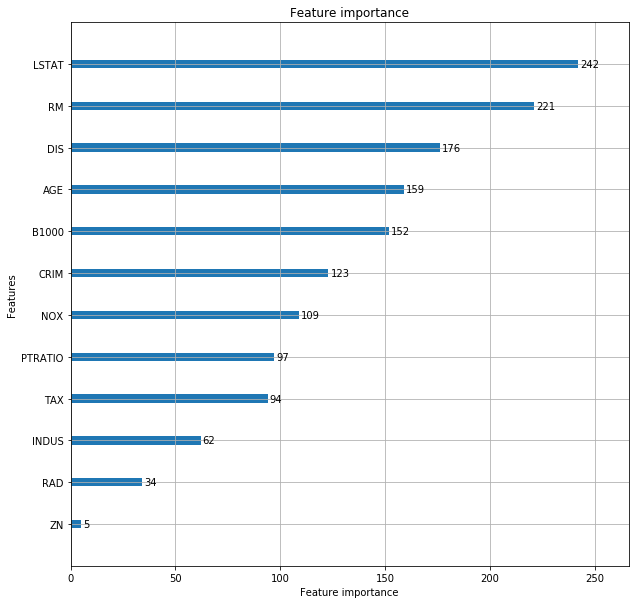

In [19]:
### 스플릿에서 사용된 횟수에 따른 변수 중요도 나열
### linear 리그레션과달리 RM 보다 LSTAT이 더 많이 쓰였습니다.

fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_importance(booster=lgbmres_notrans.best_estimator_.booster_,ax=ax,max_num_features=50)

#### SHAP를 통한 피쳐 중요도 탐색
SHAP는 최근에 많이 쓰이는 피쳐 중요도 탐색 방법으로, 딥모델에서도 쓰이고 스테이블한 결과 더 풍부한 해석을 제공하는 장점이 있습니다.


In [20]:
X = data.loc[:, data.columns != 'MEDV']
shap.initjs()

explainer = shap.TreeExplainer(lgbmres_notrans.best_estimator_.booster_)
shap_values = explainer.shap_values(X)


아래에서 색은 붉은 값이 높은 값이고, 파란색이 낮은 값 입니다.<br>
X 축에서 양에 속하면 스코어 상승에 영향을 주고, 음에 속하면 스코어 하락에 영향을 주는 것 입니다.<br>

#### 변수별 타겟에 대한 영향 해석
LSTAT 가 높을수록 타겟 값이 작아지고, 낮을수록 커짐 (저상태 인구의 비율이 높을 수록 집값은 높음)<br>
RM 이 높을 수록 타겟 값이 커기고, 낮을수록 작아짐 (방의 갯수가 많을 수록 집값은 높음)<br>
PTRATIO 높을 수록 타겟 값이 작아지고, 낮을수록 커짐 (초등학교 교생이 적을 수록 집값이 높음)<br>
DIS 높을 수록 타겟 값이 작아지고, 낮을 수록 커짐 (고용 센터와의 거리가 멀 수록 집값이 높음)<br>
NOX 가 높을 수록 집값이 낮은편 (일산화질소 농도가 높을 수록 집값이 낮음)<br>

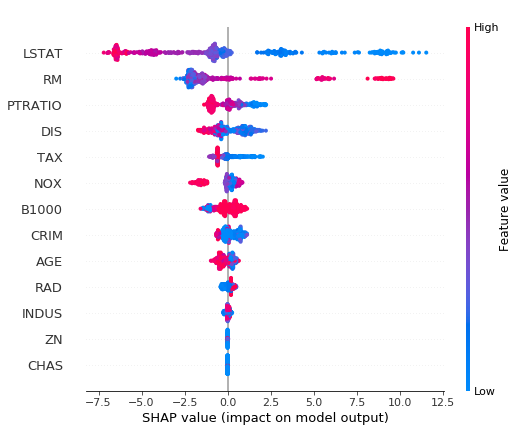

In [21]:
shap.summary_plot(shap_values, X)

하나의 예시에 대해서, 최종 스코어에 영향을 주는 변수들을 표현할 수 있습니다.

LSTAT이 작은 값으로 예측값을 올리는데 가장 큰 영향을 주었고, 그다음으로 PTRATIO 도 작은 값으로 예측 값을 올리는데 영향이 있었습닏. 그다음으로는 RM 이 작은 값으로 예측 값을 내리는데 영향을 주었습니다.

In [22]:
print('true',data.loc[0, 'MEDV'])
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

true 24.0


아래와 같이 모든 샘플에 대한 변수 별 영향 확인도 할 수 있습니다.

In [23]:
shap.force_plot(explainer.expected_value, shap_values, X)
